# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

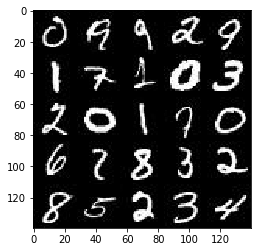

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

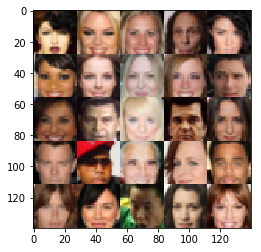

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels))
    input_z = tf.placeholder(tf.float32,(None,z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.001
        initializer=tf.contrib.layers.xavier_initializer()
        # Input layer 28x28x3
        x = tf.layers.conv2d(images,32,5,strides=2,padding='same',kernel_initializer=initializer)
        x = tf.layers.batch_normalization(x,training=True)
        x = tf.maximum(alpha*x,x)
        x = tf.nn.dropout(x,0.8)
        # 14x14x32
        x = tf.layers.conv2d(x,64,5,strides=2,padding='same',kernel_initializer=initializer)
        x = tf.layers.batch_normalization(x,training=True)
        x = tf.maximum(alpha*x,x)
        x = tf.nn.dropout(x,0.8)
        # 7x7x64
        x = tf.layers.conv2d(x,128,3,strides=1,padding='same',kernel_initializer=initializer)
        x = tf.layers.batch_normalization(x,training=True)
        x = tf.maximum(alpha*x,x)
        x = tf.nn.dropout(x,0.8)
        # 7x7x128
        
        x = tf.reshape(x,(-1,7*7*128))
        logits = tf.layers.dense(x,1,activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator',reuse=not is_train):
        alpha = 0.001
        initializer=tf.contrib.layers.xavier_initializer()
        # First fully connected layer
        x = tf.layers.dense(z,7*7*512,activation=None)
        x = tf.reshape(x,(-1,7,7,512))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha*x,x)
        x = tf.nn.dropout(x,0.8)
        # 7x7x512
        x = tf.layers.conv2d_transpose(x,256,5,strides=2,padding='same',kernel_initializer=initializer)
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha*x,x)
        x = tf.nn.dropout(x,0.8)
        # 14x14x256
        x = tf.layers.conv2d_transpose(x,128,5,strides=1,padding='same',kernel_initializer=initializer)
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha*x,x)
        x = tf.nn.dropout(x,0.8)
        # 14x14x128
        logits =  tf.layers.conv2d_transpose(x,out_channel_dim,5,strides=2,padding='same',kernel_initializer=initializer)
        # 28x28x out_channel_dim
        out = 0.5*tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.9*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    sample_z = np.random.uniform(-0.5, 0.5, size=(72, z_dim))
    if data_image_mode == 'RGB':
        channel_dim = 3
    else:
        channel_dim = 1
    #print('data_shape:',data_shape)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    samples = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step+=1
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                #print(batch_z.shape)
                #print(batch_images.shape)
                _ = sess.run(g_train_opt,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})
                _ = sess.run(d_train_opt,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})
                train_loss_d = sess.run(d_loss,feed_dict={input_real:batch_images,input_z:batch_z})
                train_loss_g = sess.run(g_loss,feed_dict={input_z:batch_z})
                if step%10 ==0:
                    print('step:',step)
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if step%100 ==0:
                    show_generator_output(sess, 16, input_z, channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

step: 10
Epoch 1/2... Discriminator Loss: 2.0897... Generator Loss: 9.3488
step: 20
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 5.9779
step: 30
Epoch 1/2... Discriminator Loss: 0.8070... Generator Loss: 2.3144
step: 40
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 2.7720
step: 50
Epoch 1/2... Discriminator Loss: 0.8529... Generator Loss: 1.6316
step: 60
Epoch 1/2... Discriminator Loss: 1.0105... Generator Loss: 2.9973
step: 70
Epoch 1/2... Discriminator Loss: 1.8393... Generator Loss: 4.7800
step: 80
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 3.6338
step: 90
Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 2.0054
step: 100
Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 1.8373


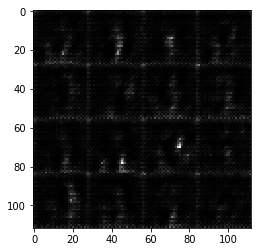

step: 110
Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 1.1390
step: 120
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 2.6966
step: 130
Epoch 1/2... Discriminator Loss: 0.9774... Generator Loss: 2.1886
step: 140
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 2.1451
step: 150
Epoch 1/2... Discriminator Loss: 1.1875... Generator Loss: 1.0997
step: 160
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 1.2128
step: 170
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 2.1920
step: 180
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 1.6742
step: 190
Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 2.0532
step: 200
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 1.2674


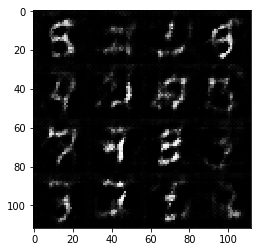

step: 210
Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 2.3351
step: 220
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 0.9574
step: 230
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 0.9971
step: 240
Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 1.3447
step: 250
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 1.0121
step: 260
Epoch 1/2... Discriminator Loss: 1.3486... Generator Loss: 0.7784
step: 270
Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 0.7093
step: 280
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.9182
step: 290
Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 1.6677
step: 300
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 1.5192


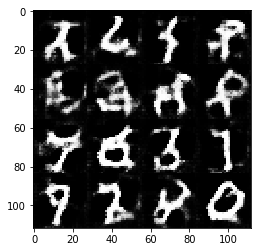

step: 310
Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 1.0946
step: 320
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 2.0528
step: 330
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 1.0708
step: 340
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 0.9727
step: 350
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.9057
step: 360
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 1.2004
step: 370
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.9354
step: 380
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 1.3622
step: 390
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 1.5381
step: 400
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 0.8516


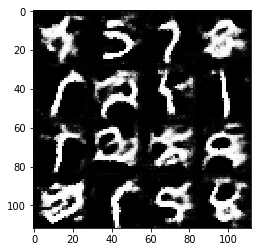

step: 410
Epoch 1/2... Discriminator Loss: 1.2172... Generator Loss: 1.2694
step: 420
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.8629
step: 430
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 1.7943
step: 440
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.8497
step: 450
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.8659
step: 460
Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 0.8121
step: 470
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 1.7713
step: 480
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 1.1343
step: 490
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 1.1383
step: 500
Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 0.9241


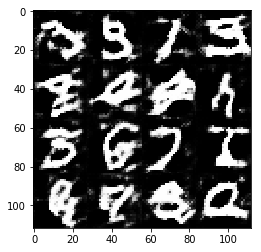

step: 510
Epoch 1/2... Discriminator Loss: 1.4893... Generator Loss: 1.7528
step: 520
Epoch 1/2... Discriminator Loss: 1.1416... Generator Loss: 1.2016
step: 530
Epoch 1/2... Discriminator Loss: 1.1955... Generator Loss: 0.8931
step: 540
Epoch 1/2... Discriminator Loss: 1.2005... Generator Loss: 0.9922
step: 550
Epoch 1/2... Discriminator Loss: 1.4144... Generator Loss: 0.5520
step: 560
Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 1.3809
step: 570
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 1.4302
step: 580
Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 1.0209
step: 590
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 0.6712
step: 600
Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.9507


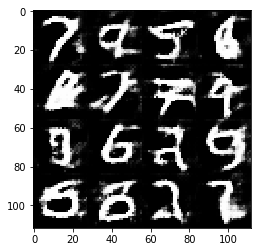

step: 610
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 1.4213
step: 620
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 0.9968
step: 630
Epoch 1/2... Discriminator Loss: 1.1143... Generator Loss: 1.2145
step: 640
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 0.9335
step: 650
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 0.7323
step: 660
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 1.0050
step: 670
Epoch 1/2... Discriminator Loss: 1.1520... Generator Loss: 1.1403
step: 680
Epoch 1/2... Discriminator Loss: 1.2609... Generator Loss: 1.6448
step: 690
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 1.1250
step: 700
Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 1.0848


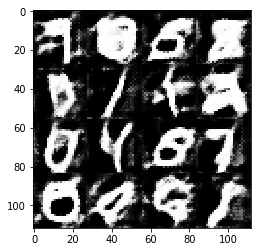

step: 710
Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 1.1728
step: 720
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.9886
step: 730
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 1.4701
step: 740
Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 1.2168
step: 750
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 1.2295
step: 760
Epoch 1/2... Discriminator Loss: 1.2406... Generator Loss: 0.9055
step: 770
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 0.9160
step: 780
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 1.0919
step: 790
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 1.9411
step: 800
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.9871


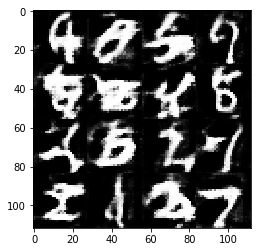

step: 810
Epoch 1/2... Discriminator Loss: 1.2891... Generator Loss: 1.4463
step: 820
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 1.3427
step: 830
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 1.3390
step: 840
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 0.9954
step: 850
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.6681
step: 860
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.7000
step: 870
Epoch 1/2... Discriminator Loss: 1.4277... Generator Loss: 1.5706
step: 880
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.7535
step: 890
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 1.1910
step: 900
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 0.9908


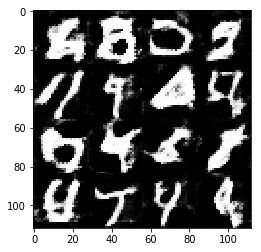

step: 910
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.8109
step: 920
Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 1.1462
step: 930
Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 0.9125
step: 940
Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 1.3182
step: 950
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 1.4462
step: 960
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 1.1277
step: 970
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 1.4574
step: 980
Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 1.1648
step: 990
Epoch 2/2... Discriminator Loss: 1.1157... Generator Loss: 1.2477
step: 1000
Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 1.2005


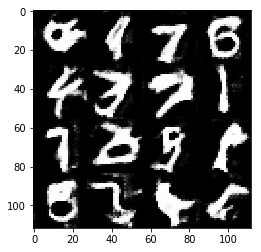

step: 1010
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 0.8496
step: 1020
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.5915
step: 1030
Epoch 2/2... Discriminator Loss: 1.1255... Generator Loss: 1.0338
step: 1040
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 1.2040
step: 1050
Epoch 2/2... Discriminator Loss: 1.1370... Generator Loss: 0.8136
step: 1060
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 1.9087
step: 1070
Epoch 2/2... Discriminator Loss: 1.2188... Generator Loss: 0.8538
step: 1080
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 1.1726
step: 1090
Epoch 2/2... Discriminator Loss: 1.1414... Generator Loss: 1.0735
step: 1100
Epoch 2/2... Discriminator Loss: 1.2617... Generator Loss: 1.5228


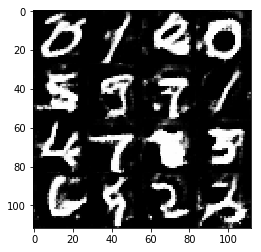

step: 1110
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 1.7348
step: 1120
Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 1.3376
step: 1130
Epoch 2/2... Discriminator Loss: 1.1045... Generator Loss: 1.1939
step: 1140
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.7328
step: 1150
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 0.8396
step: 1160
Epoch 2/2... Discriminator Loss: 1.1088... Generator Loss: 1.1110
step: 1170
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 1.6630
step: 1180
Epoch 2/2... Discriminator Loss: 1.2293... Generator Loss: 0.8174
step: 1190
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 1.2102
step: 1200
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 1.4475


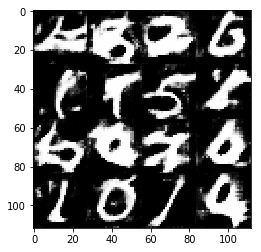

step: 1210
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 0.6313
step: 1220
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 1.6836
step: 1230
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 1.0754
step: 1240
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 1.6369
step: 1250
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.9161
step: 1260
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.9356
step: 1270
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 1.1161
step: 1280
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 0.9669
step: 1290
Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 1.6542
step: 1300
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 0.9730


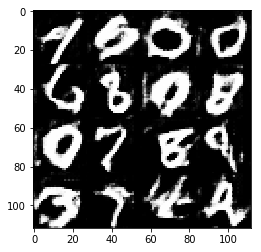

step: 1310
Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 1.3250
step: 1320
Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 0.9696
step: 1330
Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 1.1667
step: 1340
Epoch 2/2... Discriminator Loss: 1.1483... Generator Loss: 1.5446
step: 1350
Epoch 2/2... Discriminator Loss: 1.1903... Generator Loss: 1.7657
step: 1360
Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 1.3625
step: 1370
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 1.1855
step: 1380
Epoch 2/2... Discriminator Loss: 1.2564... Generator Loss: 0.8155
step: 1390
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 1.1706
step: 1400
Epoch 2/2... Discriminator Loss: 1.1176... Generator Loss: 1.7250


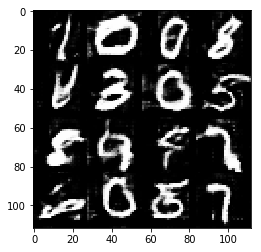

step: 1410
Epoch 2/2... Discriminator Loss: 1.0955... Generator Loss: 1.0958
step: 1420
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 1.5790
step: 1430
Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 1.2244
step: 1440
Epoch 2/2... Discriminator Loss: 1.0665... Generator Loss: 1.2293
step: 1450
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.8319
step: 1460
Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.7922
step: 1470
Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 1.5147
step: 1480
Epoch 2/2... Discriminator Loss: 1.0478... Generator Loss: 1.3091
step: 1490
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 1.2626
step: 1500
Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 1.0278


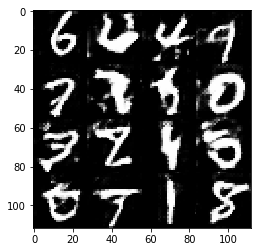

step: 1510
Epoch 2/2... Discriminator Loss: 1.2699... Generator Loss: 0.9558
step: 1520
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 0.8523
step: 1530
Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 1.0635
step: 1540
Epoch 2/2... Discriminator Loss: 1.2726... Generator Loss: 1.8392
step: 1550
Epoch 2/2... Discriminator Loss: 1.0234... Generator Loss: 1.0187
step: 1560
Epoch 2/2... Discriminator Loss: 1.0959... Generator Loss: 1.0170
step: 1570
Epoch 2/2... Discriminator Loss: 1.1905... Generator Loss: 1.6066
step: 1580
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 1.6592
step: 1590
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 0.9086
step: 1600
Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 1.0086


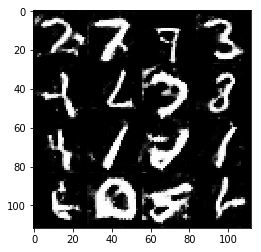

step: 1610
Epoch 2/2... Discriminator Loss: 1.0939... Generator Loss: 1.1697
step: 1620
Epoch 2/2... Discriminator Loss: 1.1431... Generator Loss: 1.1930
step: 1630
Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 1.2504
step: 1640
Epoch 2/2... Discriminator Loss: 1.0509... Generator Loss: 1.5323
step: 1650
Epoch 2/2... Discriminator Loss: 1.0817... Generator Loss: 1.2382
step: 1660
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 2.0463
step: 1670
Epoch 2/2... Discriminator Loss: 1.0352... Generator Loss: 1.3454
step: 1680
Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 1.2110
step: 1690
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 1.1501
step: 1700
Epoch 2/2... Discriminator Loss: 1.0609... Generator Loss: 1.0266


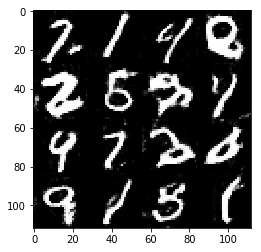

step: 1710
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 1.1304
step: 1720
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 1.4483
step: 1730
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 0.9225
step: 1740
Epoch 2/2... Discriminator Loss: 1.1987... Generator Loss: 0.9418
step: 1750
Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 1.6709
step: 1760
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 1.2598
step: 1770
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 1.0593
step: 1780
Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 1.0101
step: 1790
Epoch 2/2... Discriminator Loss: 1.0765... Generator Loss: 1.1614
step: 1800
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 0.8199


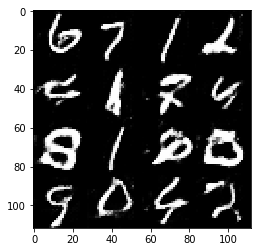

step: 1810
Epoch 2/2... Discriminator Loss: 1.1364... Generator Loss: 0.9370
step: 1820
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.9830
step: 1830
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 1.4112
step: 1840
Epoch 2/2... Discriminator Loss: 0.9714... Generator Loss: 1.6209
step: 1850
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 1.1813
step: 1860
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 1.4166
step: 1870
Epoch 2/2... Discriminator Loss: 1.0408... Generator Loss: 1.5724


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

step: 10
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 5.7005
step: 20
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 3.5707
step: 30
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 4.5705
step: 40
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 3.1154
step: 50
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 2.6231
step: 60
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.7900
step: 70
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.9452
step: 80
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 2.8206
step: 90
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 3.1923
step: 100
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 2.6999


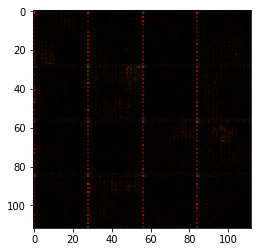

step: 110
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.9497
step: 120
Epoch 1/1... Discriminator Loss: 0.6961... Generator Loss: 2.4607
step: 130
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 2.9269
step: 140
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 1.6799
step: 150
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 2.0074
step: 160
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 3.6759
step: 170
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 2.3584
step: 180
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 3.3474
step: 190
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.6565
step: 200
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 1.4035


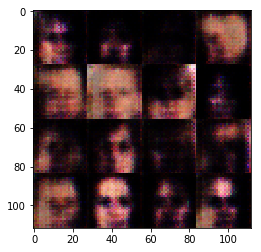

step: 210
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.4911
step: 220
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.3337
step: 230
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.7708
step: 240
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.3997
step: 250
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 2.0203
step: 260
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.7657
step: 270
Epoch 1/1... Discriminator Loss: 0.6217... Generator Loss: 2.9990
step: 280
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.7826
step: 290
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.8688
step: 300
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.9424


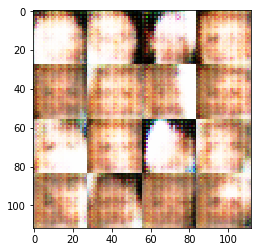

step: 310
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.2150
step: 320
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 2.5877
step: 330
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 2.1697
step: 340
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 2.5744
step: 350
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 2.1931
step: 360
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.9738
step: 370
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.2743
step: 380
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.6823
step: 390
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.9358
step: 400
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 1.1859


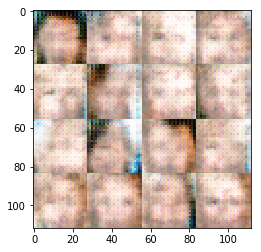

step: 410
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 1.7268
step: 420
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 2.1206
step: 430
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 1.5975
step: 440
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.7103
step: 450
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 1.4482
step: 460
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.6720
step: 470
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.4583
step: 480
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 1.5656
step: 490
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 1.4333
step: 500
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 1.1850


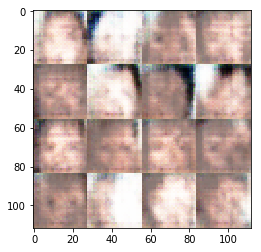

step: 510
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 1.1733
step: 520
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.0657
step: 530
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 1.2066
step: 540
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 1.1823
step: 550
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 1.1831
step: 560
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 1.3416
step: 570
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.4403
step: 580
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 1.2137
step: 590
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.5620
step: 600
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.2483


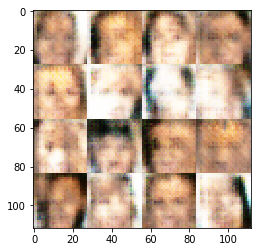

step: 610
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.1806
step: 620
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 1.3596
step: 630
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 2.1083
step: 640
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 1.0292
step: 650
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.4162
step: 660
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 1.3723
step: 670
Epoch 1/1... Discriminator Loss: 1.0015... Generator Loss: 1.5340
step: 680
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.3428
step: 690
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 1.4221
step: 700
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.7456


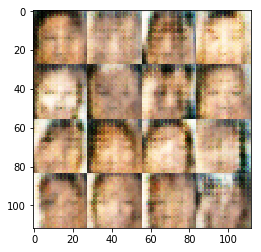

step: 710
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.2793
step: 720
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 1.1142
step: 730
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 1.0323
step: 740
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 1.1877
step: 750
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 1.3380
step: 760
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.1922
step: 770
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.1358
step: 780
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.1741
step: 790
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 1.3257
step: 800
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 1.3881


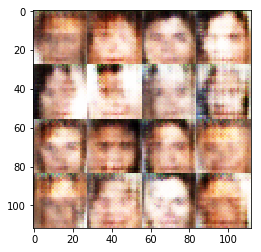

step: 810
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.8846
step: 820
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.9714
step: 830
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.7168
step: 840
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 1.3692
step: 850
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.9569
step: 860
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.9310
step: 870
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 1.1168
step: 880
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 1.1714
step: 890
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 1.5550
step: 900
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 1.1021


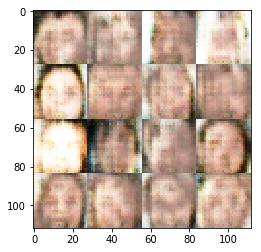

step: 910
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 1.2084
step: 920
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 1.3098
step: 930
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.8386
step: 940
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 1.3720
step: 950
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.9955
step: 960
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 1.0567
step: 970
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 1.2424
step: 980
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 1.1623
step: 990
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 1.2805
step: 1000
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 1.0570


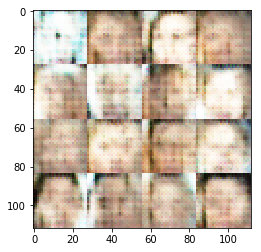

step: 1010
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.1266
step: 1020
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.9764
step: 1030
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.7944
step: 1040
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.8132
step: 1050
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 1.1079
step: 1060
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 1.0059
step: 1070
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 1.2851
step: 1080
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 1.1287
step: 1090
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.3343
step: 1100
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.9466


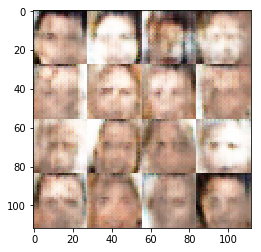

step: 1110
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 1.0868
step: 1120
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.2652
step: 1130
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7345
step: 1140
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 1.0533
step: 1150
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 1.0198
step: 1160
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8804
step: 1170
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 1.0408
step: 1180
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8850
step: 1190
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 1.0775
step: 1200
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 1.1693


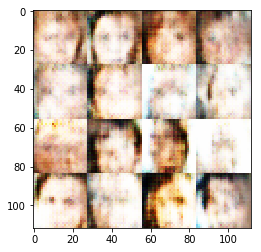

step: 1210
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.9771
step: 1220
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.9794
step: 1230
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 1.0953
step: 1240
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.0683
step: 1250
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 1.1682
step: 1260
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.8945
step: 1270
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.0251
step: 1280
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 1.0453
step: 1290
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 1.3217
step: 1300
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.9973


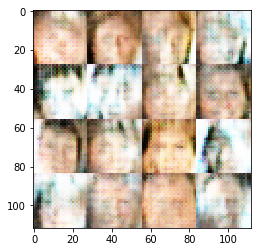

step: 1310
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 1.0034
step: 1320
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.9795
step: 1330
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.9029
step: 1340
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 1.2377
step: 1350
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.3841
step: 1360
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.8393
step: 1370
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.0511
step: 1380
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.9830
step: 1390
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 1.0744
step: 1400
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.8833


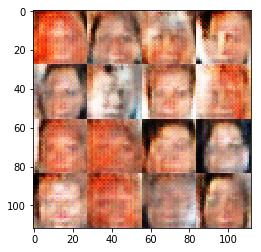

step: 1410
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 1.0270
step: 1420
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.0848
step: 1430
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 1.2510
step: 1440
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 1.1744
step: 1450
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 1.1642
step: 1460
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.9248
step: 1470
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 1.0803
step: 1480
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8884
step: 1490
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.9252
step: 1500
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.2646


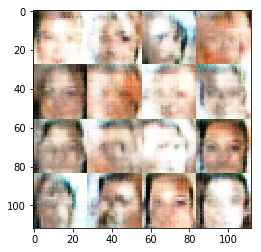

step: 1510
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 1.0850
step: 1520
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.9072
step: 1530
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 1.0386
step: 1540
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 1.1779
step: 1550
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.9898
step: 1560
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7475
step: 1570
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.1802
step: 1580
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.9713
step: 1590
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 1.1172
step: 1600
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 1.0691


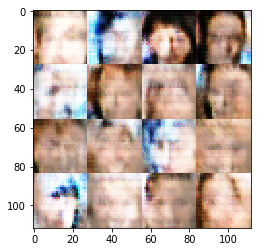

step: 1610
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 1.2149
step: 1620
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 1.1184
step: 1630
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 1.3177
step: 1640
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.8594
step: 1650
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.9896
step: 1660
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 1.1198
step: 1670
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 1.1981
step: 1680
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.9770
step: 1690
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8912
step: 1700
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.0169


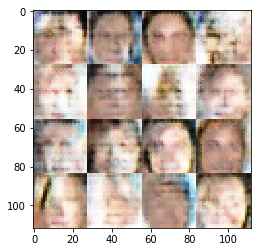

step: 1710
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.8921
step: 1720
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.9546
step: 1730
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.1357
step: 1740
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8416
step: 1750
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.0683
step: 1760
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.0604
step: 1770
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.9175
step: 1780
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8396
step: 1790
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 1.1724
step: 1800
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.9792


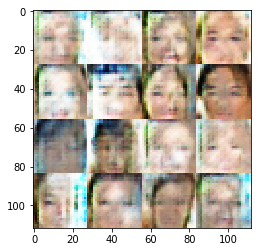

step: 1810
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 1.0265
step: 1820
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.0761
step: 1830
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.9914
step: 1840
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.9049
step: 1850
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.9785
step: 1860
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 1.1914
step: 1870
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 1.0962
step: 1880
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.9905
step: 1890
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.9604
step: 1900
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.8316


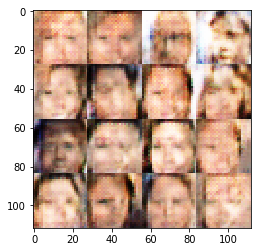

step: 1910
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.1992
step: 1920
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 1.0394
step: 1930
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 1.0430
step: 1940
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 1.1938
step: 1950
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8885
step: 1960
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.9676
step: 1970
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.9133
step: 1980
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.0050
step: 1990
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.9856
step: 2000
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.9604


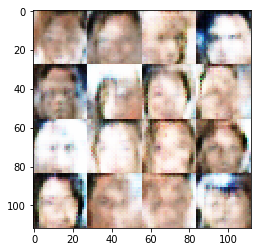

step: 2010
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.9570
step: 2020
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 1.0103
step: 2030
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 1.0373
step: 2040
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.9293
step: 2050
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 1.0903
step: 2060
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.0139
step: 2070
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.9731
step: 2080
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 1.0751
step: 2090
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 1.0180
step: 2100
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.9279


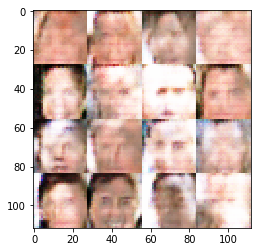

step: 2110
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 1.0956
step: 2120
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7862
step: 2130
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.9953
step: 2140
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.9566
step: 2150
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8781
step: 2160
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.1646
step: 2170
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.9874
step: 2180
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.9813
step: 2190
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 1.0010
step: 2200
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 1.0267


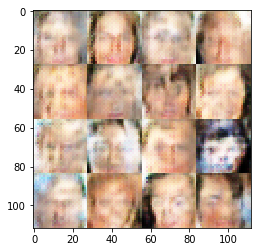

step: 2210
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.9730
step: 2220
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.9706
step: 2230
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.0363
step: 2240
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 1.0215
step: 2250
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.9792
step: 2260
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 1.0227
step: 2270
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 1.0341
step: 2280
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.9888
step: 2290
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 1.0551
step: 2300
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.9909


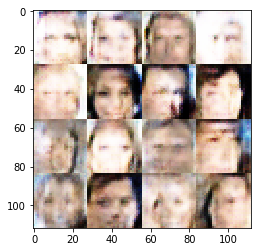

step: 2310
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.8595
step: 2320
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.9331
step: 2330
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.9891
step: 2340
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 1.0492
step: 2350
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 1.0159
step: 2360
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 1.1518
step: 2370
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 1.0177
step: 2380
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.9470
step: 2390
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.9604
step: 2400
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.8038


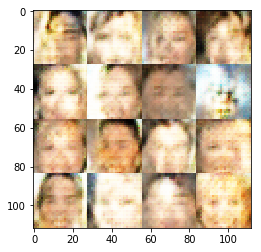

step: 2410
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.9380
step: 2420
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.9932
step: 2430
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.9251
step: 2440
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.9516
step: 2450
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.9259
step: 2460
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8533
step: 2470
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.9778
step: 2480
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8960
step: 2490
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.8814
step: 2500
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 1.0340


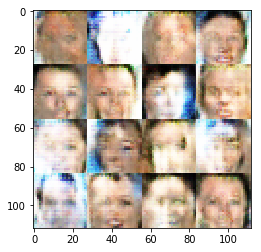

step: 2510
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.8346
step: 2520
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.9025
step: 2530
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 1.0529
step: 2540
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.9411
step: 2550
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.9601
step: 2560
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.9013
step: 2570
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.9616
step: 2580
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.7414
step: 2590
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.9275
step: 2600
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.7935


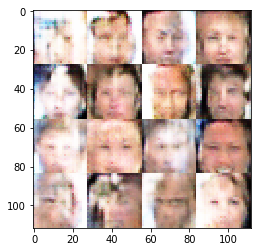

step: 2610
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.9434
step: 2620
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 1.0537
step: 2630
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.9111
step: 2640
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7650
step: 2650
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.7400
step: 2660
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.9306
step: 2670
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.9240
step: 2680
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.8149
step: 2690
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.9250
step: 2700
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.9288


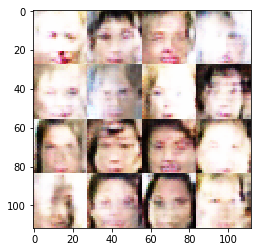

step: 2710
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.8818
step: 2720
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 1.0065
step: 2730
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.9663
step: 2740
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 1.0842
step: 2750
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.9064
step: 2760
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.9086
step: 2770
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.8866
step: 2780
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8786
step: 2790
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7196
step: 2800
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.8719


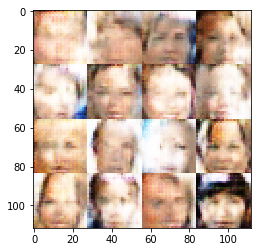

step: 2810
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8343
step: 2820
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.8536
step: 2830
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.9433
step: 2840
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8600
step: 2850
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.8608
step: 2860
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.9486
step: 2870
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.9456
step: 2880
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.9750
step: 2890
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.9926
step: 2900
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.9087


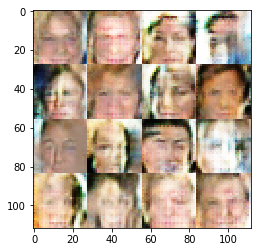

step: 2910
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8362
step: 2920
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.9954
step: 2930
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.9158
step: 2940
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.9469
step: 2950
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.9396
step: 2960
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8740
step: 2970
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8251
step: 2980
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.8773
step: 2990
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.8926
step: 3000
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8574


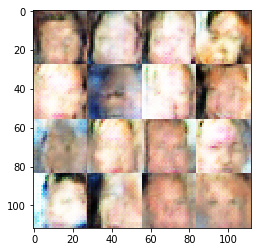

step: 3010
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8681
step: 3020
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8524
step: 3030
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.8978
step: 3040
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7736
step: 3050
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8907
step: 3060
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.9575
step: 3070
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.9705
step: 3080
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8848
step: 3090
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.9083
step: 3100
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.9069


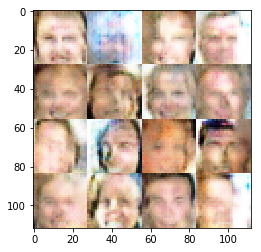

step: 3110
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.9284
step: 3120
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.9004
step: 3130
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8705
step: 3140
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.9038
step: 3150
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8563
step: 3160
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8396
step: 3170
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8328
step: 3180
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.9827
step: 3190
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.8822
step: 3200
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8161


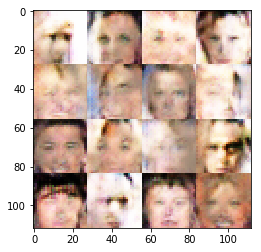

step: 3210
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.8866
step: 3220
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.9600
step: 3230
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7950
step: 3240
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.9338
step: 3250
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.8889
step: 3260
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.9241
step: 3270
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7977
step: 3280
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.8626
step: 3290
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.8393
step: 3300
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8308


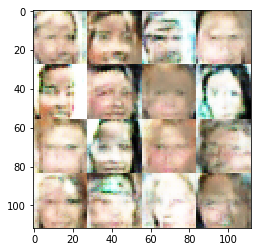

step: 3310
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.7943
step: 3320
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7893
step: 3330
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.8988
step: 3340
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8927
step: 3350
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8589
step: 3360
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8695
step: 3370
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.8425
step: 3380
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.9586
step: 3390
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8172
step: 3400
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.9037


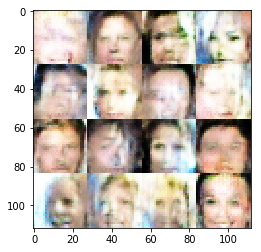

step: 3410
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8884
step: 3420
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.8415
step: 3430
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.9086
step: 3440
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.8103
step: 3450
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.9169
step: 3460
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8210
step: 3470
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8156
step: 3480
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.8548
step: 3490
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.8447
step: 3500
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.8443


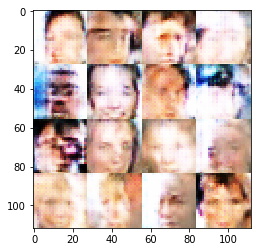

step: 3510
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7850
step: 3520
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8748
step: 3530
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.9048
step: 3540
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8313
step: 3550
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8933
step: 3560
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.9090
step: 3570
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8321
step: 3580
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8996
step: 3590
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.8926
step: 3600
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.8733


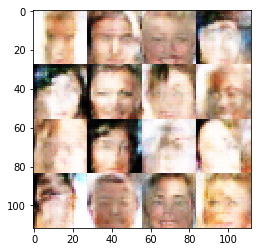

step: 3610
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.8414
step: 3620
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7608
step: 3630
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.8640
step: 3640
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.9762
step: 3650
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.8445
step: 3660
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8501
step: 3670
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8528
step: 3680
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8776
step: 3690
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.9257
step: 3700
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7778


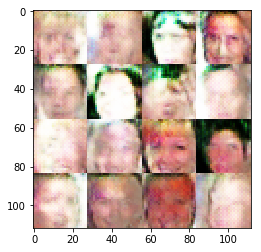

step: 3710
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.8199
step: 3720
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8110
step: 3730
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.9322
step: 3740
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7892
step: 3750
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7805
step: 3760
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.8334
step: 3770
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8760
step: 3780
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7552
step: 3790
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.8054
step: 3800
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 1.0368


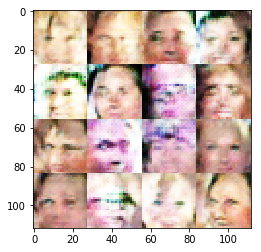

step: 3810
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8383
step: 3820
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8753
step: 3830
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.9339
step: 3840
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8846
step: 3850
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.8670
step: 3860
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.9104
step: 3870
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.8778
step: 3880
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.8452
step: 3890
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.8219
step: 3900
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.8304


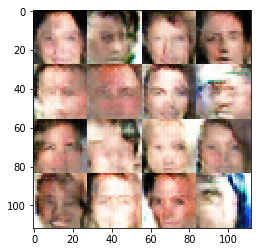

step: 3910
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8706
step: 3920
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8476
step: 3930
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.8548
step: 3940
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8359
step: 3950
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.8773
step: 3960
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.8335
step: 3970
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.8858
step: 3980
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8526
step: 3990
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8547
step: 4000
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.9031


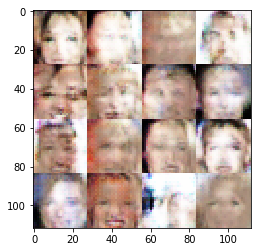

step: 4010
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7550
step: 4020
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8120
step: 4030
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8124
step: 4040
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.7964
step: 4050
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8813
step: 4060
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7825
step: 4070
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 1.0848
step: 4080
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8064
step: 4090
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7918
step: 4100
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7633


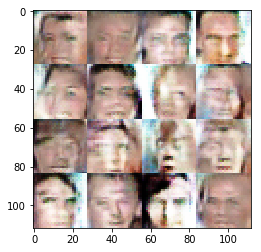

step: 4110
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.8986
step: 4120
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7903
step: 4130
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.8413
step: 4140
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.9002
step: 4150
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.8774
step: 4160
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8400
step: 4170
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7934
step: 4180
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.8065
step: 4190
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7557
step: 4200
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.8384


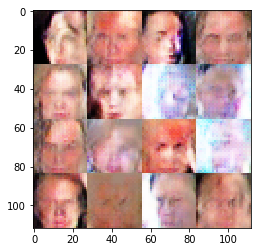

step: 4210
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.8623
step: 4220
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.9198
step: 4230
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.8796
step: 4240
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.8211
step: 4250
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7516
step: 4260
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8468
step: 4270
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8282
step: 4280
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.9338
step: 4290
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8138
step: 4300
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8900


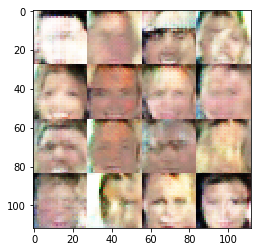

step: 4310
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7990
step: 4320
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8656
step: 4330
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8722
step: 4340
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.9008
step: 4350
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.9417
step: 4360
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.7868
step: 4370
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.8067
step: 4380
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8068
step: 4390
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.8430
step: 4400
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7737


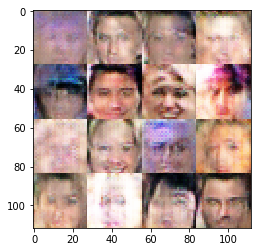

step: 4410
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8635
step: 4420
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.9155
step: 4430
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.8632
step: 4440
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8109
step: 4450
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.8294
step: 4460
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8609
step: 4470
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.9083
step: 4480
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.9216
step: 4490
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8460
step: 4500
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7623


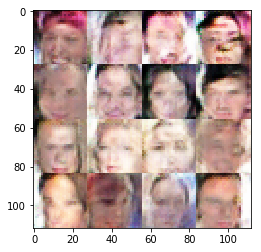

step: 4510
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8715
step: 4520
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.9088
step: 4530
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.9191
step: 4540
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8512
step: 4550
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.8135
step: 4560
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7365
step: 4570
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7695
step: 4580
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8961
step: 4590
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8664
step: 4600
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7780


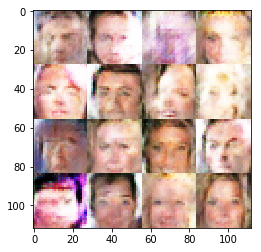

step: 4610
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7882
step: 4620
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7822
step: 4630
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7778
step: 4640
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.8458
step: 4650
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.8492
step: 4660
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8110
step: 4670
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8238
step: 4680
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8075
step: 4690
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.8517
step: 4700
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7886


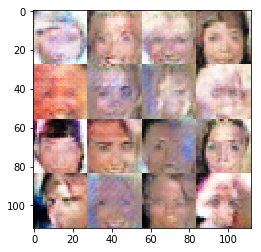

step: 4710
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.9258
step: 4720
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7999
step: 4730
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7794
step: 4740
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7076
step: 4750
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7634
step: 4760
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7846
step: 4770
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.7604
step: 4780
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8806
step: 4790
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8740
step: 4800
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.8497


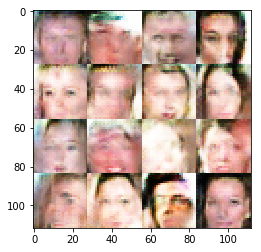

step: 4810
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8229
step: 4820
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.7665
step: 4830
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8417
step: 4840
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.9190
step: 4850
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.8594
step: 4860
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.8759
step: 4870
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.8298
step: 4880
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7869
step: 4890
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8181
step: 4900
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7724


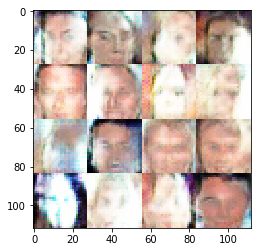

step: 4910
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8739
step: 4920
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8196
step: 4930
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8243
step: 4940
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.8358
step: 4950
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.7530
step: 4960
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7879
step: 4970
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8495
step: 4980
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8039
step: 4990
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8484
step: 5000
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.9371


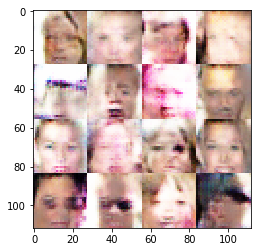

step: 5010
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7402
step: 5020
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8013
step: 5030
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.8950
step: 5040
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.9582
step: 5050
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7889
step: 5060
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8851
step: 5070
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7610
step: 5080
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8148
step: 5090
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.9133
step: 5100
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7412


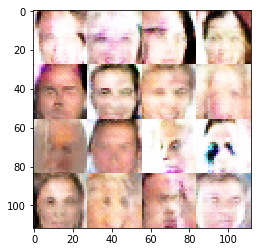

step: 5110
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8370
step: 5120
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8252
step: 5130
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7781
step: 5140
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7696
step: 5150
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.9306
step: 5160
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8414
step: 5170
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7649
step: 5180
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.8574
step: 5190
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.8438
step: 5200
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8099


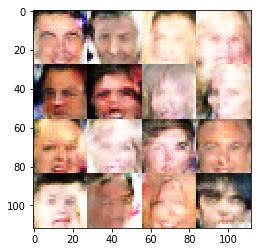

step: 5210
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7677
step: 5220
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8417
step: 5230
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8603
step: 5240
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.8821
step: 5250
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.8403
step: 5260
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7769
step: 5270
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7588
step: 5280
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8411
step: 5290
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8357
step: 5300
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8937


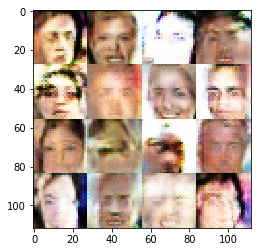

step: 5310
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.9201
step: 5320
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7778
step: 5330
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8360
step: 5340
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.8100
step: 5350
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8634
step: 5360
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8299
step: 5370
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.8580
step: 5380
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.7967
step: 5390
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7860
step: 5400
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8278


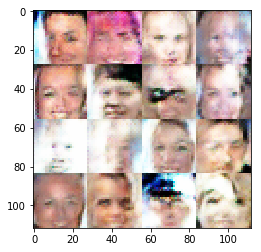

step: 5410
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7860
step: 5420
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8448
step: 5430
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8095
step: 5440
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7983
step: 5450
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8898
step: 5460
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8143
step: 5470
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7775
step: 5480
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8835
step: 5490
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.8344
step: 5500
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8925


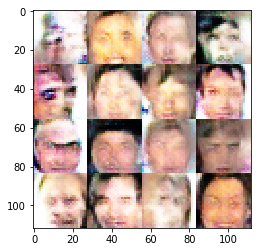

step: 5510
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8300
step: 5520
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8352
step: 5530
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7948
step: 5540
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7756
step: 5550
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8637
step: 5560
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7108
step: 5570
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.8707
step: 5580
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8169
step: 5590
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8408
step: 5600
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7259


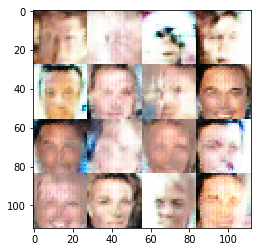

step: 5610
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8485
step: 5620
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8139
step: 5630
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.8407
step: 5640
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7799
step: 5650
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8536
step: 5660
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7912
step: 5670
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.8373
step: 5680
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7909
step: 5690
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8695
step: 5700
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7551


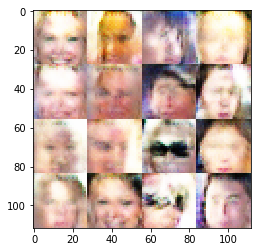

step: 5710
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.8044
step: 5720
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8199
step: 5730
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8604
step: 5740
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8517
step: 5750
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.8494
step: 5760
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8207
step: 5770
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7710
step: 5780
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.9549
step: 5790
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8803
step: 5800
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.6920


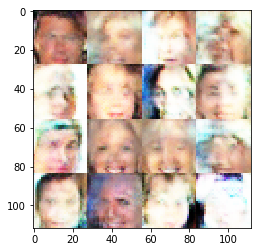

step: 5810
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.8924
step: 5820
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.8051
step: 5830
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7531
step: 5840
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.8221
step: 5850
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7965
step: 5860
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8379
step: 5870
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8114
step: 5880
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8179
step: 5890
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8307
step: 5900
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8219


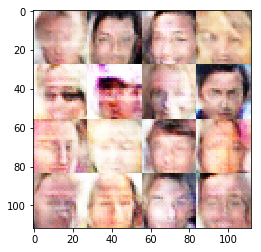

step: 5910
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7296
step: 5920
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.8011
step: 5930
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8362
step: 5940
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7758
step: 5950
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8549
step: 5960
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.7748
step: 5970
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8438
step: 5980
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7858
step: 5990
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8328
step: 6000
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8189


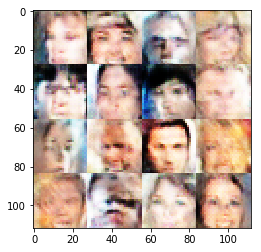

step: 6010
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7860
step: 6020
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8445
step: 6030
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7765
step: 6040
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.9212
step: 6050
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7179
step: 6060
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8873
step: 6070
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8101
step: 6080
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7963
step: 6090
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.8964
step: 6100
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.7823


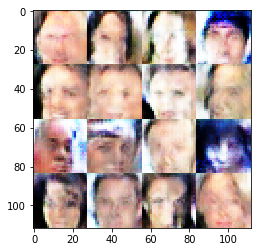

step: 6110
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8314
step: 6120
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8455
step: 6130
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7720
step: 6140
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8180
step: 6150
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.8170
step: 6160
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7375
step: 6170
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.8293
step: 6180
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7878
step: 6190
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8059
step: 6200
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8080


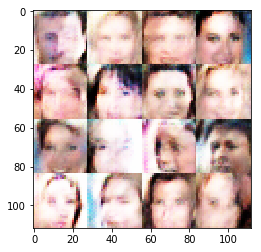

step: 6210
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.8710
step: 6220
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8322
step: 6230
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7174
step: 6240
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.9041
step: 6250
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7866
step: 6260
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8414
step: 6270
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.7969
step: 6280
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.8179
step: 6290
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7966
step: 6300
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8318


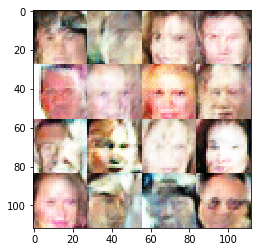

step: 6310
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8100
step: 6320
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7715
step: 6330
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8327


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.